In [2]:
import cv2
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/esmira23/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/esmira23/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/esmira23/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load data, display column names and dataset size

In [13]:
df = pd.read_csv('heart.csv')
print(f'Dataset size: {df.shape}')
df.head()

Dataset size: (303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Work out gaps

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


#### Normalize the data

In [15]:
scaler = preprocessing.MinMaxScaler()
columns_names = df.columns
dt_transform = scaler.fit_transform(df)
scaled_dataset = pd.DataFrame(dt_transform, columns=columns_names)
scaled_dataset.head(100)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.00,0.333333,1.0
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.00,0.666667,1.0
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.00,0.666667,1.0
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.00,0.666667,1.0
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.00,0.666667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.500000,1.0,0.000000,0.452830,0.228311,0.0,0.0,0.305344,1.0,0.000000,1.0,0.00,1.000000,1.0
96,0.687500,0.0,0.000000,0.433962,0.611872,0.0,0.0,0.656489,0.0,0.193548,0.5,0.00,0.666667,1.0
97,0.479167,1.0,0.000000,0.132075,0.244292,1.0,0.5,0.580153,0.0,0.016129,1.0,0.75,1.000000,1.0
98,0.291667,1.0,0.666667,0.339623,0.431507,0.0,0.5,0.694656,0.0,0.306452,1.0,0.25,0.666667,1.0


In [16]:
x = scaled_dataset.drop('output', axis=1);
y = scaled_dataset['output'];

In [17]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1. Dimensionality reduction and data visualization

#### PCA

In [103]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x)
pca_result_df = pd.DataFrame({'pca_1': pca_result[:,0], 'pca_2': pca_result[:,1], 'label': y})


##### PCA result visualization

<Axes: xlabel='pca_1', ylabel='pca_2'>

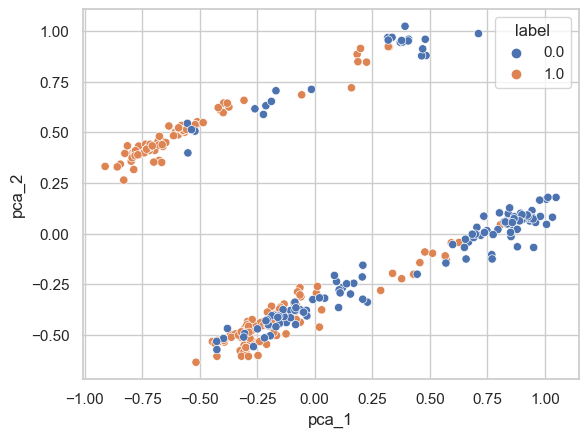

In [104]:
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df)

#### TSNE

In [105]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(x)
tsne_result_df = pd.DataFrame({'pca_1': tsne_result[:,0], 'pca_2': tsne_result[:,1],'label' : y})

##### TSNE result visualization

<Axes: xlabel='pca_1', ylabel='pca_2'>

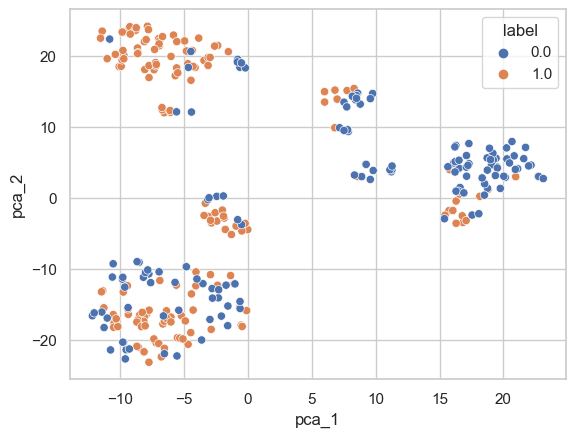

In [106]:
sns.scatterplot(data=tsne_result_df, x='pca_1', y='pca_2', hue='label')

### 2. Cluster analysis

Using the k-means algorithm, perform image quantization (removal of visually redundant information) with a depth of 64, 32, 16 and 8 levels for any self-selected image.

In [18]:
def kmeans_quantization(image, k):
    w, h, d = tuple(image.shape)
    assert d == 3
    image_array = np.reshape(image, (w * h, d))
    
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(image_array)

    cluster_centers = kmeans.cluster_centers_
    # replace each pixel with its corresponding cluster center
    quantized_image = np.reshape(cluster_centers[labels], (w, h, d)) # replace each pixel with its corresponding cluster center
    quantized_image = np.uint8(quantized_image) # convert the quantized image back to uint8 format
    result = cv2.cvtColor(quantized_image, cv2.COLOR_BGR2RGB)

    return result

(-0.5, 3023.5, 4031.5, -0.5)

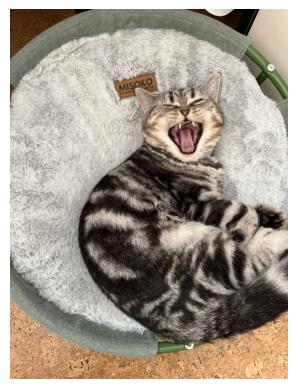

In [19]:
image = cv2.imread("cat.jpeg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")


#### Image quantization with a depth of 64

(-0.5, 3023.5, 4031.5, -0.5)

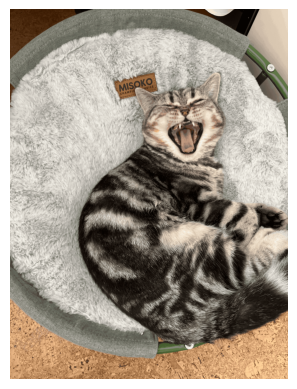

In [121]:
image_64 = kmeans_quantization(image, 64)
plt.imshow(image_64)
plt.axis("off")

#### Image quantization with a depth of 32

(-0.5, 3023.5, 4031.5, -0.5)

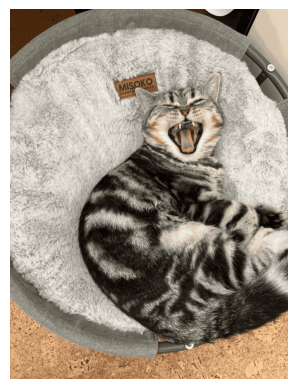

In [122]:
image_32 = kmeans_quantization(image, 32)
plt.imshow(image_32)
plt.axis("off")

#### Image quantization with a depth of 16

(-0.5, 3023.5, 4031.5, -0.5)

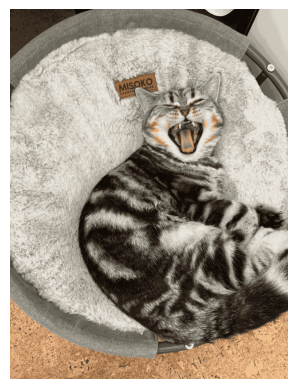

In [21]:
image_16 = kmeans_quantization(image, 16)
plt.imshow(image_16)
plt.axis("off")

#### Image quantization with a depth of 8

(-0.5, 3023.5, 4031.5, -0.5)

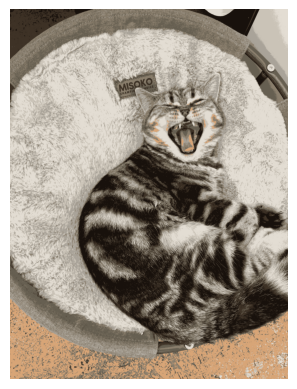

In [124]:
image_8 = kmeans_quantization(image, 8)
plt.imshow(image_8)
plt.axis("off")

### 3. Processing and classification of text data

#### Download a text dataset (with class labels)

In [4]:
dataset = pd.read_csv("tweets.csv")
dataset.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
dataset = dataset[['text', 'sentiment']]
dataset.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [6]:
dataset = dataset.dropna()
dataset.sentiment.value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

#### Refine the data (remove stop words, punctuation), use wordcloud to visualize the most common words or n-grams in each class.

In [10]:
stop_words = stopwords.words('english')
def text_preprocessing(text):
    text = text.lower()
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)

    for i in word_tokens:
        if i not in stop_words:
                text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # remove punctuations
                
                # remove extra spaces
                text = re.sub('\n', ' ', text)
                text = re.sub('\s{2,}',' ', text)
                text = wordnet_lemmatizer.lemmatize(text)
                
                text = re.sub('[^a-zA-Z\s]', '', text) # remove non-Latin characters
    return text

dataset['text'] = dataset['text'].apply(text_preprocessing)

#### Visualize the most common words

##### Sentiment - Neutral

(-0.5, 399.5, 199.5, -0.5)

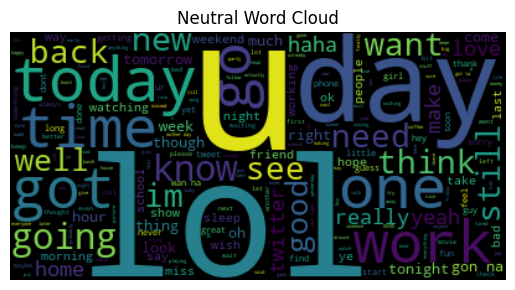

In [11]:
label1 = ' '.join(dataset[dataset.sentiment == 'neutral'].text.tolist())
label1 = WordCloud().generate(label1)

plt.imshow(label1, interpolation='bilinear')
plt.title('Neutral Word Cloud')
plt.axis('off')

##### Sentiment - Positive

(-0.5, 399.5, 199.5, -0.5)

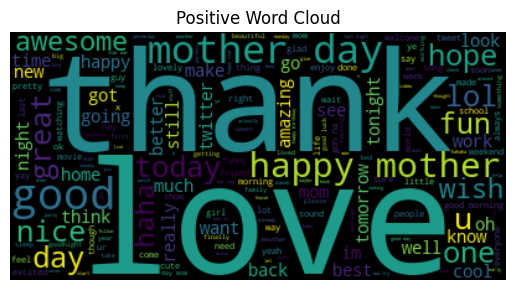

In [12]:
label2 = ' '.join(dataset[dataset.sentiment == 'positive'].text.tolist())
label2 = WordCloud().generate(label2)

plt.imshow(label2, interpolation='bilinear')
plt.title('Positive Word Cloud')
plt.axis('off')

##### Sentiment - Negative

(-0.5, 399.5, 199.5, -0.5)

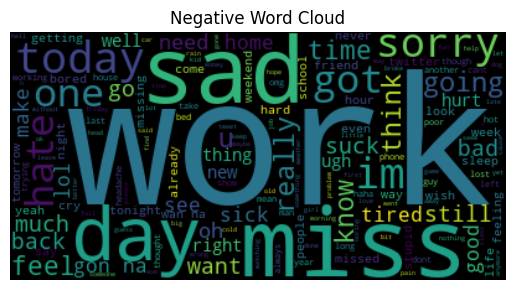

In [13]:
label3 = ' '.join(dataset[dataset.sentiment == 'negative'].text.tolist())
label3 = WordCloud().generate(label3)

plt.imshow(label3, interpolation='bilinear')
plt.title('Negative Word Cloud')
plt.axis('off')

#### Vectorization with TFIDF

In [14]:
tfidf = TfidfVectorizer()
text_transformed = tfidf.fit_transform(dataset['text'])

#### Classify text data

In [15]:
x_train, x_test, y_train, y_test = train_test_split(text_transformed, dataset['sentiment'], test_size=0.2, random_state=42)

##### LogisticRegression

In [17]:
model = LogisticRegression(max_iter=20)
model.fit(x_train, y_train)
pred = model.predict(x_test)

print(f'Classification report: \n{classification_report(y_test, pred)}\n')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, pred)}\n')
print(f'Accuracy: {accuracy_score(y_test, pred)}')

Classification report: 
              precision    recall  f1-score   support

    negative       0.71      0.58      0.64      1572
     neutral       0.62      0.76      0.68      2236
    positive       0.79      0.69      0.73      1688

    accuracy                           0.69      5496
   macro avg       0.71      0.68      0.69      5496
weighted avg       0.70      0.69      0.69      5496


Confusion Matrix: 
[[ 905  583   84]
 [ 295 1707  234]
 [  66  458 1164]]

Accuracy: 0.6870451237263464


In [16]:
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
best_accuracy = []
for i in range(1, 100):
    model = LogisticRegression(max_iter=i)
    model.fit(x_train, y_train)
    pred_i = model.predict(x_test)
    best_accuracy.append(accuracy_score(y_test, pred_i))

print('The best iterator:', best_accuracy.index(max(best_accuracy)) + 1)

The best iterator: 20


##### MultinomialNB

In [20]:
nb_model = MultinomialNB(alpha=1)
nb_model.fit(x_train, y_train)
prediction = nb_model.predict(x_test)

print(f'Classification report: \n{classification_report(y_test, prediction)}\n')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, prediction)}\n')
print(f'Accuracy: {accuracy_score(y_test, prediction)}')

Classification report: 
              precision    recall  f1-score   support

    negative       0.78      0.40      0.53      1572
     neutral       0.54      0.82      0.66      2236
    positive       0.74      0.57      0.65      1688

    accuracy                           0.63      5496
   macro avg       0.69      0.60      0.61      5496
weighted avg       0.67      0.63      0.62      5496


Confusion Matrix: 
[[ 635  853   84]
 [ 148 1841  247]
 [  35  687  966]]

Accuracy: 0.62627365356623


In [18]:
i, best_accuracy = 0, []
while i < 1:
    model = MultinomialNB(alpha=1)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    best_accuracy.append(accuracy_score(y_test, pred_i))
    i = i + 0.005
print('The best afpha:', best_accuracy.index(max(best_accuracy)) + 1)

The best afpha: 1
